In [ ]:
!pip install pydtmc==8.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.3 which is incompatible.
op

In [1]:
import pandas as pd

df = pd.read_csv('definitivo-oficial-fase2-limiar50(2).csv')

df

,Unnamed: 0,Veículo,grid_origem,grid_destino,dia,contagem
0,197,181,66030,75312,Friday,5
1,198,181,66030,75312,Friday,5
2,199,181,66030,75312,Friday,5
3,200,181,66030,75312,Friday,5
4,201,181,66030,75312,Friday,5
...,...,...,...,...,...,...
2124,3765,597,30422,69926,Wednesday,5
2125,3766,597,30422,69926,Wednesday,5
2126,3767,597,30422,69926,Wednesday,5
2127,3768,597,30422,69926,Wednesday,5


In [2]:
markov = pd.read_csv('markov.csv')

markov.rename(columns={'fold_precisions': 'fold', 'mean_precision':'precision'}, inplace=True)

markov.to_csv('markov.csv')

In [3]:
hmm = pd.read_csv('hmm (2).csv')

hmm.rename(columns={'fold_precisions': 'fold', 'mean_precision':'precision'}, inplace=True)

hmm.to_csv('hmm.csv')

**Para médias das médias, hierarquizadamente: por veículo, por fold e por repetições de fold por veículo**

=== TESTE SHAPIRO-WILK HIERÁRQUICO: MARKOV E HMM ===

1. CARREGANDO DADOS DE MARKOV...

ANÁLISE MARKOV

Dados carregados: 2300 registros
Estrutura:
  Veículos: 23
  Repetições: 10
  Folds: 10

1. NÍVEL 1: MÉDIA DIRETA POR VEÍCULO
   (Média de todas as precisões de cada veículo)

Teste de Shapiro-Wilk (23 médias):
  Estatística W = 0.937696
  p-value = 0.160336
  Conclusão: Distribuição NORMAL (α = 0.05)

Estatísticas:
  Média geral = 0.590835
  Desvio padrão = 0.184062

2. NÍVEL 2: MÉDIA POR VEÍCULO DAS MÉDIAS DOS FOLDS
   (Primeiro calcula média de cada fold, depois média dos folds por veículo)

Teste de Shapiro-Wilk (23 médias):
  Estatística W = 0.937696
  p-value = 0.160336
  Conclusão: Distribuição NORMAL (α = 0.05)

Estatísticas:
  Média geral = 0.590835
  Desvio padrão = 0.184062

3. NÍVEL 3: MÉDIA POR VEÍCULO DAS MÉDIAS DAS REPETIÇÕES
   (Média de cada fold por repetição, depois média das repetições, depois média por veículo)

Teste de Shapiro-Wilk (23 médias):
  Estatística W 

/tmp/ipython-input-730638180.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_box, labels=['Markov', 'HMM'])


✓ Gráficos salvos em 'shapiro_wilk_hierarquico_correto.png'

5. SALVANDO RESULTADOS...
✓ Comparação salva em 'shapiro_comparison_hierarquico.csv'
✓ Dados MARKOV salvos
✓ Dados HMM salvos

=== ANÁLISE CONCLUÍDA ===

INTERPRETAÇÃO:
- Todos os níveis resultam em 23 valores (um por veículo)
- As médias finais são iguais, mas a distribuição pode variar
- Nível 1: Agregação direta de todos os valores
- Nível 2: Agregação hierárquica via folds
- Nível 3: Agregação hierárquica via repetições

Diferentes agregações podem resultar em diferentes distribuições!


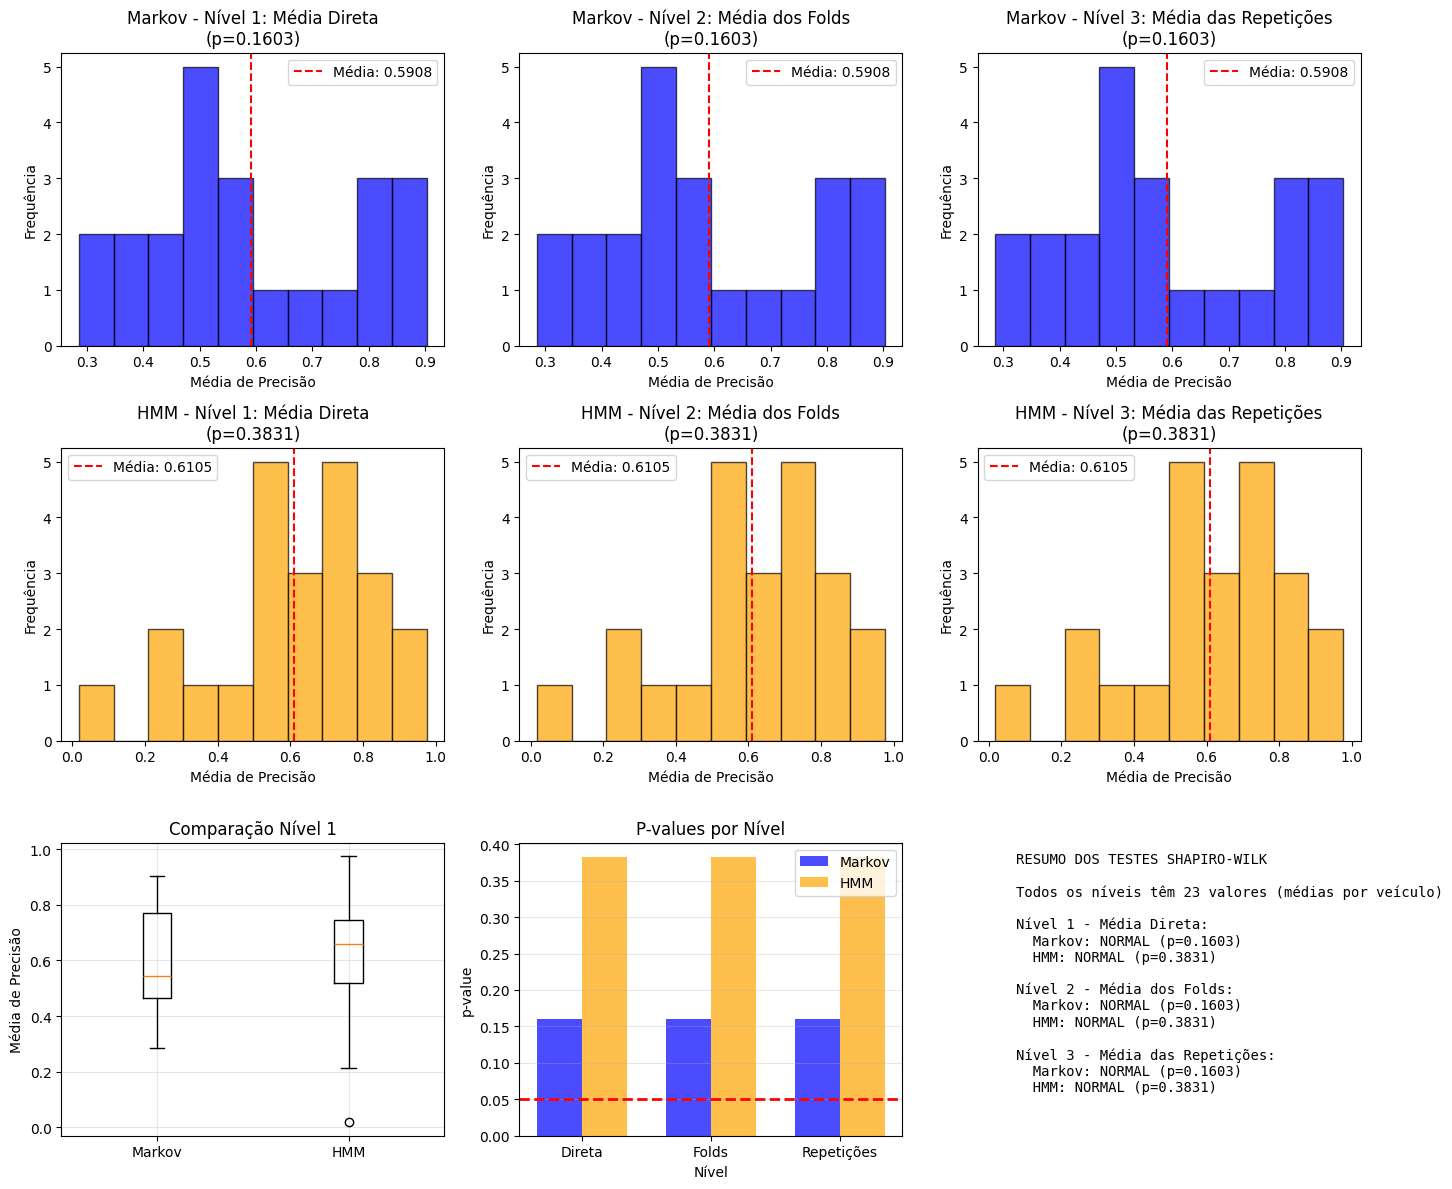

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', message='Input data has range zero')

print("=== TESTE SHAPIRO-WILK HIERÁRQUICO: MARKOV E HMM ===\n")

# Função para processar cada método
def analyze_method(df, method_name):
    print(f"\n{'='*60}")
    print(f"ANÁLISE {method_name.upper()}")
    print(f"{'='*60}")

    print(f"\nDados carregados: {len(df)} registros")
    print(f"Estrutura:")
    print(f"  Veículos: {df['vehicle_id'].nunique()}")
    print(f"  Repetições: {df['repeat'].nunique()}")
    print(f"  Folds: {df['fold'].nunique()}")

    results = {}

    # NÍVEL 1: MÉDIA DIRETA POR VEÍCULO
    print(f"\n1. NÍVEL 1: MÉDIA DIRETA POR VEÍCULO")
    print("   (Média de todas as precisões de cada veículo)")

    # Calcular médias diretas por veículo
    vehicle_means_nivel1 = df.groupby('vehicle_id')['precision'].agg(['mean', 'std', 'count']).reset_index()
    vehicle_means_nivel1.columns = ['vehicle_id', 'mean_precision', 'std_precision', 'n_values']

    # Teste de Shapiro-Wilk
    means_array_nivel1 = vehicle_means_nivel1['mean_precision'].values

    if len(means_array_nivel1) >= 3:
        stat_nivel1, p_nivel1 = shapiro(means_array_nivel1)
        is_normal_nivel1 = p_nivel1 > 0.05
    else:
        stat_nivel1, p_nivel1 = None, None
        is_normal_nivel1 = None

    print(f"\nTeste de Shapiro-Wilk ({len(vehicle_means_nivel1)} médias):")
    print(f"  Estatística W = {stat_nivel1:.6f}")
    print(f"  p-value = {p_nivel1:.6f}")
    print(f"  Conclusão: Distribuição {'NORMAL' if is_normal_nivel1 else 'NÃO NORMAL'} (α = 0.05)")

    print(f"\nEstatísticas:")
    print(f"  Média geral = {np.mean(means_array_nivel1):.6f}")
    print(f"  Desvio padrão = {np.std(means_array_nivel1):.6f}")

    results['nivel1'] = {
        'data': vehicle_means_nivel1,
        'shapiro_stat': stat_nivel1,
        'shapiro_p': p_nivel1,
        'is_normal': is_normal_nivel1,
        'n_groups': len(vehicle_means_nivel1)
    }

    # NÍVEL 2: MÉDIA POR VEÍCULO DAS MÉDIAS DOS FOLDS
    print(f"\n2. NÍVEL 2: MÉDIA POR VEÍCULO DAS MÉDIAS DOS FOLDS")
    print("   (Primeiro calcula média de cada fold, depois média dos folds por veículo)")

    # Passo 1: Calcular média de cada fold dentro de cada veículo
    fold_means = df.groupby(['vehicle_id', 'fold'])['precision'].mean().reset_index()

    # Passo 2: Calcular média dos folds por veículo
    vehicle_means_nivel2 = fold_means.groupby('vehicle_id')['precision'].agg(['mean', 'std', 'count']).reset_index()
    vehicle_means_nivel2.columns = ['vehicle_id', 'mean_precision', 'std_fold_means', 'n_folds']

    # Teste de Shapiro-Wilk
    means_array_nivel2 = vehicle_means_nivel2['mean_precision'].values

    if len(means_array_nivel2) >= 3:
        stat_nivel2, p_nivel2 = shapiro(means_array_nivel2)
        is_normal_nivel2 = p_nivel2 > 0.05
    else:
        stat_nivel2, p_nivel2 = None, None
        is_normal_nivel2 = None

    print(f"\nTeste de Shapiro-Wilk ({len(vehicle_means_nivel2)} médias):")
    print(f"  Estatística W = {stat_nivel2:.6f}")
    print(f"  p-value = {p_nivel2:.6f}")
    print(f"  Conclusão: Distribuição {'NORMAL' if is_normal_nivel2 else 'NÃO NORMAL'} (α = 0.05)")

    print(f"\nEstatísticas:")
    print(f"  Média geral = {np.mean(means_array_nivel2):.6f}")
    print(f"  Desvio padrão = {np.std(means_array_nivel2):.6f}")

    results['nivel2'] = {
        'data': vehicle_means_nivel2,
        'shapiro_stat': stat_nivel2,
        'shapiro_p': p_nivel2,
        'is_normal': is_normal_nivel2,
        'n_groups': len(vehicle_means_nivel2)
    }

    # NÍVEL 3: MÉDIA POR VEÍCULO DAS MÉDIAS DAS REPETIÇÕES (DAS MÉDIAS DOS FOLDS)
    print(f"\n3. NÍVEL 3: MÉDIA POR VEÍCULO DAS MÉDIAS DAS REPETIÇÕES")
    print("   (Média de cada fold por repetição, depois média das repetições, depois média por veículo)")

    # Passo 1: Calcular média de cada repetição (já considerando os folds)
    repeat_means = df.groupby(['vehicle_id', 'repeat'])['precision'].mean().reset_index()

    # Passo 2: Calcular média das repetições por veículo
    vehicle_means_nivel3 = repeat_means.groupby('vehicle_id')['precision'].agg(['mean', 'std', 'count']).reset_index()
    vehicle_means_nivel3.columns = ['vehicle_id', 'mean_precision', 'std_repeat_means', 'n_repeats']

    # Teste de Shapiro-Wilk
    means_array_nivel3 = vehicle_means_nivel3['mean_precision'].values

    if len(means_array_nivel3) >= 3:
        stat_nivel3, p_nivel3 = shapiro(means_array_nivel3)
        is_normal_nivel3 = p_nivel3 > 0.05
    else:
        stat_nivel3, p_nivel3 = None, None
        is_normal_nivel3 = None

    print(f"\nTeste de Shapiro-Wilk ({len(vehicle_means_nivel3)} médias):")
    print(f"  Estatística W = {stat_nivel3:.6f}")
    print(f"  p-value = {p_nivel3:.6f}")
    print(f"  Conclusão: Distribuição {'NORMAL' if is_normal_nivel3 else 'NÃO NORMAL'} (α = 0.05)")

    print(f"\nEstatísticas:")
    print(f"  Média geral = {np.mean(means_array_nivel3):.6f}")
    print(f"  Desvio padrão = {np.std(means_array_nivel3):.6f}")

    results['nivel3'] = {
        'data': vehicle_means_nivel3,
        'shapiro_stat': stat_nivel3,
        'shapiro_p': p_nivel3,
        'is_normal': is_normal_nivel3,
        'n_groups': len(vehicle_means_nivel3)
    }

    return results

# 1. CARREGAR E ANALISAR MARKOV
print("1. CARREGANDO DADOS DE MARKOV...")
markov_df = pd.read_csv('markov.csv')
markov_results = analyze_method(markov_df, 'Markov')

# 2. CARREGAR E ANALISAR HMM
print("\n2. CARREGANDO DADOS DE HMM...")
hmm_df = pd.read_csv('hmm.csv')
hmm_results = analyze_method(hmm_df, 'HMM')

# 3. COMPARAÇÃO E VISUALIZAÇÕES
print(f"\n{'='*60}")
print("COMPARAÇÃO MARKOV vs HMM")
print(f"{'='*60}")

# Criar tabela comparativa
comparison_data = []
for nivel in ['nivel1', 'nivel2', 'nivel3']:
    nivel_name = {
        'nivel1': 'Média Direta',
        'nivel2': 'Média das Médias dos Folds',
        'nivel3': 'Média das Médias das Repetições'
    }[nivel]

    comparison_data.append({
        'Nível': nivel_name,
        'Markov_n': markov_results[nivel]['n_groups'],
        'Markov_p': markov_results[nivel]['shapiro_p'],
        'Markov_normal': markov_results[nivel]['is_normal'],
        'HMM_n': hmm_results[nivel]['n_groups'],
        'HMM_p': hmm_results[nivel]['shapiro_p'],
        'HMM_normal': hmm_results[nivel]['is_normal']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nResumo Comparativo (todos os níveis têm 23 valores - um por veículo):")
print(comparison_df.to_string(index=False))

# Verificar se as médias são iguais ou diferentes entre níveis
print("\n\nVERIFICAÇÃO: As médias devem ser iguais entre os níveis")
for method, results in [('Markov', markov_results), ('HMM', hmm_results)]:
    print(f"\n{method}:")
    means_n1 = results['nivel1']['data']['mean_precision'].values
    means_n2 = results['nivel2']['data']['mean_precision'].values
    means_n3 = results['nivel3']['data']['mean_precision'].values

    print(f"  Média Nível 1: {np.mean(means_n1):.6f}")
    print(f"  Média Nível 2: {np.mean(means_n2):.6f}")
    print(f"  Média Nível 3: {np.mean(means_n3):.6f}")
    print(f"  Diferença máxima entre níveis: {max(abs(np.mean(means_n1) - np.mean(means_n2)), abs(np.mean(means_n2) - np.mean(means_n3))):.8f}")

# 4. VISUALIZAÇÕES
print("\n4. GERANDO VISUALIZAÇÕES...")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Linha 1: Comparação dos 3 níveis - Markov
for i, nivel in enumerate(['nivel1', 'nivel2', 'nivel3']):
    ax = axes[0, i]
    means = markov_results[nivel]['data']['mean_precision'].values

    ax.hist(means, bins=10, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(x=np.mean(means), color='red', linestyle='--', label=f'Média: {np.mean(means):.4f}')

    nivel_name = {
        'nivel1': 'Nível 1: Média Direta',
        'nivel2': 'Nível 2: Média dos Folds',
        'nivel3': 'Nível 3: Média das Repetições'
    }[nivel]

    ax.set_title(f'Markov - {nivel_name}\n(p={markov_results[nivel]["shapiro_p"]:.4f})')
    ax.set_xlabel('Média de Precisão')
    ax.set_ylabel('Frequência')
    ax.legend()

# Linha 2: Comparação dos 3 níveis - HMM
for i, nivel in enumerate(['nivel1', 'nivel2', 'nivel3']):
    ax = axes[1, i]
    means = hmm_results[nivel]['data']['mean_precision'].values

    ax.hist(means, bins=10, alpha=0.7, color='orange', edgecolor='black')
    ax.axvline(x=np.mean(means), color='red', linestyle='--', label=f'Média: {np.mean(means):.4f}')

    nivel_name = {
        'nivel1': 'Nível 1: Média Direta',
        'nivel2': 'Nível 2: Média dos Folds',
        'nivel3': 'Nível 3: Média das Repetições'
    }[nivel]

    ax.set_title(f'HMM - {nivel_name}\n(p={hmm_results[nivel]["shapiro_p"]:.4f})')
    ax.set_xlabel('Média de Precisão')
    ax.set_ylabel('Frequência')
    ax.legend()

# Linha 3: Comparações diretas e resumo
# 3.1 Boxplot comparativo - Nível 1
ax1 = axes[2, 0]
data_box = [markov_results['nivel1']['data']['mean_precision'].values,
            hmm_results['nivel1']['data']['mean_precision'].values]
ax1.boxplot(data_box, labels=['Markov', 'HMM'])
ax1.set_title('Comparação Nível 1')
ax1.set_ylabel('Média de Precisão')
ax1.grid(True, alpha=0.3)

# 3.2 P-values por nível
ax2 = axes[2, 1]
p_values_markov = [markov_results[f'nivel{i}']['shapiro_p'] for i in range(1, 4)]
p_values_hmm = [hmm_results[f'nivel{i}']['shapiro_p'] for i in range(1, 4)]

x = np.arange(3)
width = 0.35

bars1 = ax2.bar(x - width/2, p_values_markov, width, label='Markov', color='blue', alpha=0.7)
bars2 = ax2.bar(x + width/2, p_values_hmm, width, label='HMM', color='orange', alpha=0.7)

ax2.axhline(y=0.05, color='red', linestyle='--', lw=2)
ax2.set_ylabel('p-value')
ax2.set_xlabel('Nível')
ax2.set_xticks(x)
ax2.set_xticklabels(['Direta', 'Folds', 'Repetições'])
ax2.set_title('P-values por Nível')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3.3 Resumo
ax3 = axes[2, 2]
ax3.axis('off')

table_text = "RESUMO DOS TESTES SHAPIRO-WILK\n\n"
table_text += "Todos os níveis têm 23 valores (médias por veículo)\n\n"

for i, nivel in enumerate(['nivel1', 'nivel2', 'nivel3']):
    nivel_name = {
        'nivel1': 'Nível 1 - Média Direta',
        'nivel2': 'Nível 2 - Média dos Folds',
        'nivel3': 'Nível 3 - Média das Repetições'
    }[nivel]

    table_text += f"{nivel_name}:\n"
    table_text += f"  Markov: {'NORMAL' if markov_results[nivel]['is_normal'] else 'NÃO NORMAL'} (p={markov_results[nivel]['shapiro_p']:.4f})\n"
    table_text += f"  HMM: {'NORMAL' if hmm_results[nivel]['is_normal'] else 'NÃO NORMAL'} (p={hmm_results[nivel]['shapiro_p']:.4f})\n\n"

ax3.text(0.1, 0.5, table_text, fontsize=10, verticalalignment='center', fontfamily='monospace')

plt.tight_layout()
plt.savefig('shapiro_wilk_hierarquico_correto.png', dpi=300)
print("✓ Gráficos salvos em 'shapiro_wilk_hierarquico_correto.png'")

# 5. SALVAR RESULTADOS
print("\n5. SALVANDO RESULTADOS...")

# Salvar comparação
comparison_df.to_csv('shapiro_comparison_hierarquico.csv', index=False)
print("✓ Comparação salva em 'shapiro_comparison_hierarquico.csv'")

# Salvar dados de cada nível
for method, results in [('markov', markov_results), ('hmm', hmm_results)]:
    for i, nivel in enumerate(['nivel1', 'nivel2', 'nivel3']):
        filename = f'{method}_nivel{i+1}_medias.csv'
        results[nivel]['data'].to_csv(filename, index=False)
    print(f"✓ Dados {method.upper()} salvos")

print("\n=== ANÁLISE CONCLUÍDA ===")
print("\nINTERPRETAÇÃO:")
print("- Todos os níveis resultam em 23 valores (um por veículo)")
print("- As médias finais são iguais, mas a distribuição pode variar")
print("- Nível 1: Agregação direta de todos os valores")
print("- Nível 2: Agregação hierárquica via folds")
print("- Nível 3: Agregação hierárquica via repetições")
print("\nDiferentes agregações podem resultar em diferentes distribuições!")

**Prosseguindo com os resultados hierarquizados**

=== TESTE T-STUDENT PARA AMOSTRAS INDEPENDENTES: MARKOV vs HMM ===

1. CARREGANDO DADOS...
✓ Markov: 2300 registros carregados
✓ HMM: 2300 registros carregados

2. CALCULANDO MÉDIAS POR VEÍCULO...
✓ 23 veículos pareados

3. TESTE T-STUDENT PARA AMOSTRAS INDEPENDENTES
--------------------------------------------------
Amostras totais: 4600
  Markov: 2300 amostras
  HMM: 2300 amostras
  Veículos pareados: 23

Médias:
  Markov: 0.590835
  HMM: 0.610519
  Diferença (Markov - HMM): -0.019684

Teste t-Student:
  t-estatística: -2.289630
  Graus de liberdade: 4598
  p-value (bilateral): 0.022088

Intervalo de Confiança 95%:
  [-0.036538, -0.002830]

Conclusão (α = 0.05):
  REJEITA H0: Há diferença significativa entre os métodos
  HMM é significativamente melhor que Markov

4. GERANDO VISUALIZAÇÕES...
✓ Gráfico salvo em 'ttest_resultado_completo.png'

5. SALVANDO RESULTADOS...
✓ Dados pareados salvos em 'ttest_dados_pareados.csv'
✓ Resumo do teste salvo em 'ttest_resumo.csv'

=== TESTE CONCLUÍ

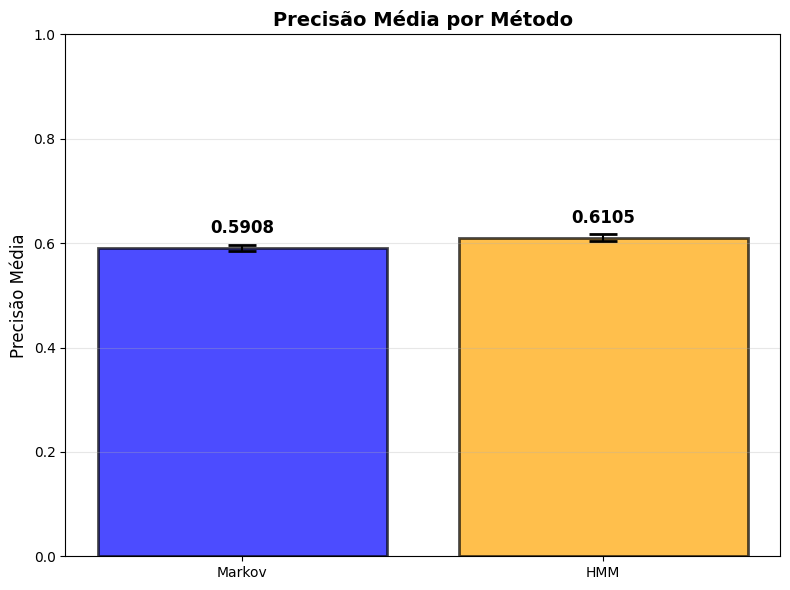

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

print("=== TESTE T-STUDENT PARA AMOSTRAS INDEPENDENTES: MARKOV vs HMM ===\n")

# 1. CARREGAR DADOS
print("1. CARREGANDO DADOS...")

# Carregar dados de Markov
markov_df = pd.read_csv('markov.csv')
print(f"✓ Markov: {len(markov_df)} registros carregados")

# Carregar dados de HMM
hmm_df = pd.read_csv('hmm.csv')
print(f"✓ HMM: {len(hmm_df)} registros carregados")

# 2. CALCULAR MÉDIAS POR VEÍCULO
print("\n2. CALCULANDO MÉDIAS POR VEÍCULO...")

# Médias por veículo - Markov
markov_means = markov_df.groupby('vehicle_id')['precision'].mean().reset_index()
markov_means.columns = ['vehicle_id', 'mean_markov']
markov_means = markov_means.sort_values('vehicle_id')

# Médias por veículo - HMM
hmm_means = hmm_df.groupby('vehicle_id')['precision'].mean().reset_index()
hmm_means.columns = ['vehicle_id', 'mean_hmm']
hmm_means = hmm_means.sort_values('vehicle_id')

# Merge para garantir pareamento
paired_data = markov_means.merge(hmm_means, on='vehicle_id', how='inner')
paired_data['difference'] = paired_data['mean_markov'] - paired_data['mean_hmm']

print(f"✓ {len(paired_data)} veículos pareados")

# 3. APLICAR TESTE T-STUDENT PARA AMOSTRAS INDEPENDENTES
print("\n3. TESTE T-STUDENT PARA AMOSTRAS INDEPENDENTES")
print("-" * 50)

# Extrair arrays dos dados originais (todas as 2300 amostras)
markov_values = markov_df['precision'].values
hmm_values = hmm_df['precision'].values

# Aplicar teste t para amostras independentes
t_statistic, p_value = ttest_ind(markov_values, hmm_values)

# Calcular médias para relatório
mean_markov = np.mean(markov_values)
mean_hmm = np.mean(hmm_values)
mean_difference = mean_markov - mean_hmm

# Estatísticas
n_markov = len(markov_values)
n_hmm = len(hmm_values)
n_total = n_markov + n_hmm
std_markov = np.std(markov_values, ddof=1)
std_hmm = np.std(hmm_values, ddof=1)

# Para relatório, manter informação dos veículos pareados
paired_vehicles = len(paired_data)

# Graus de liberdade para teste t independente
df = n_markov + n_hmm - 2

# Intervalo de confiança 95% para a diferença das médias
from scipy import stats
# Pooled standard deviation
sp_squared = ((n_markov - 1) * std_markov**2 + (n_hmm - 1) * std_hmm**2) / df
se_difference = np.sqrt(sp_squared * (1/n_markov + 1/n_hmm))
t_critical = stats.t.ppf(0.975, df)
ci_lower = mean_difference - t_critical * se_difference
ci_upper = mean_difference + t_critical * se_difference

# Imprimir resultados
print(f"Amostras totais: {n_total}")
print(f"  Markov: {n_markov} amostras")
print(f"  HMM: {n_hmm} amostras")
print(f"  Veículos pareados: {paired_vehicles}")

print(f"\nMédias:")
print(f"  Markov: {mean_markov:.6f}")
print(f"  HMM: {mean_hmm:.6f}")
print(f"  Diferença (Markov - HMM): {mean_difference:.6f}")

print(f"\nTeste t-Student:")
print(f"  t-estatística: {t_statistic:.6f}")
print(f"  Graus de liberdade: {df}")
print(f"  p-value (bilateral): {p_value:.6f}")

print(f"\nIntervalo de Confiança 95%:")
print(f"  [{ci_lower:.6f}, {ci_upper:.6f}]")

print(f"\nConclusão (α = 0.05):")
if p_value < 0.05:
    print(f"  REJEITA H0: Há diferença significativa entre os métodos")
    if mean_difference > 0:
        print(f"  Markov é significativamente melhor que HMM")
    else:
        print(f"  HMM é significativamente melhor que Markov")
else:
    print(f"  NÃO REJEITA H0: Não há diferença significativa entre os métodos")

# 4. VISUALIZAÇÃO
print("\n4. GERANDO VISUALIZAÇÕES...")

# Criar figura apenas com o gráfico de Precisão Média por Método
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Gráfico: Barras das Precisões Médias (mantendo o estilo original)
ax.bar(['Markov', 'HMM'], [mean_markov, mean_hmm],
        color=['blue', 'orange'], alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Precisão Média', fontsize=12)
ax.set_title('Precisão Média por Método', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, (method, value) in enumerate(zip(['Markov', 'HMM'], [mean_markov, mean_hmm])):
    ax.text(i, value + 0.02, f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Adicionar erro padrão (usando todas as amostras)
markov_se = std_markov / np.sqrt(n_markov)
hmm_se = std_hmm / np.sqrt(n_hmm)
ax.errorbar(['Markov', 'HMM'], [mean_markov, mean_hmm],
             yerr=[markov_se, hmm_se], fmt='none', color='black', capsize=10, capthick=2)

plt.tight_layout()
plt.savefig('ttest_resultado_completo.png', dpi=300)
print("✓ Gráfico salvo em 'ttest_resultado_completo.png'")

# 5. SALVAR RESULTADOS
print("\n5. SALVANDO RESULTADOS...")

# Dados pareados
paired_data = paired_data.sort_values('difference', ascending=False)
paired_data.to_csv('ttest_dados_pareados.csv', index=False)
print("✓ Dados pareados salvos em 'ttest_dados_pareados.csv'")

# Resumo do teste
test_summary = pd.DataFrame({
    'Estatística': ['N total (amostras)', 'N Markov', 'N HMM', 'Veículos pareados',
                    'Média Markov', 'Média HMM', 'Diferença média',
                    'Desvio padrão Markov', 'Desvio padrão HMM', 't-estatística',
                    'Graus de liberdade', 'p-value', 'IC 95% inferior',
                    'IC 95% superior', 'Significativo (α=0.05)'],
    'Valor': [n_total, n_markov, n_hmm, paired_vehicles, mean_markov, mean_hmm, mean_difference,
              std_markov, std_hmm, t_statistic, df, p_value, ci_lower, ci_upper,
              'Sim' if p_value < 0.05 else 'Não']
})

test_summary.to_csv('ttest_resumo.csv', index=False)
print("✓ Resumo do teste salvo em 'ttest_resumo.csv'")

print("\n=== TESTE CONCLUÍDO ===")

**Teste Amostras Independentes - por Veículo**

Total de pares encontrados: 2300
Veículos únicos: 23


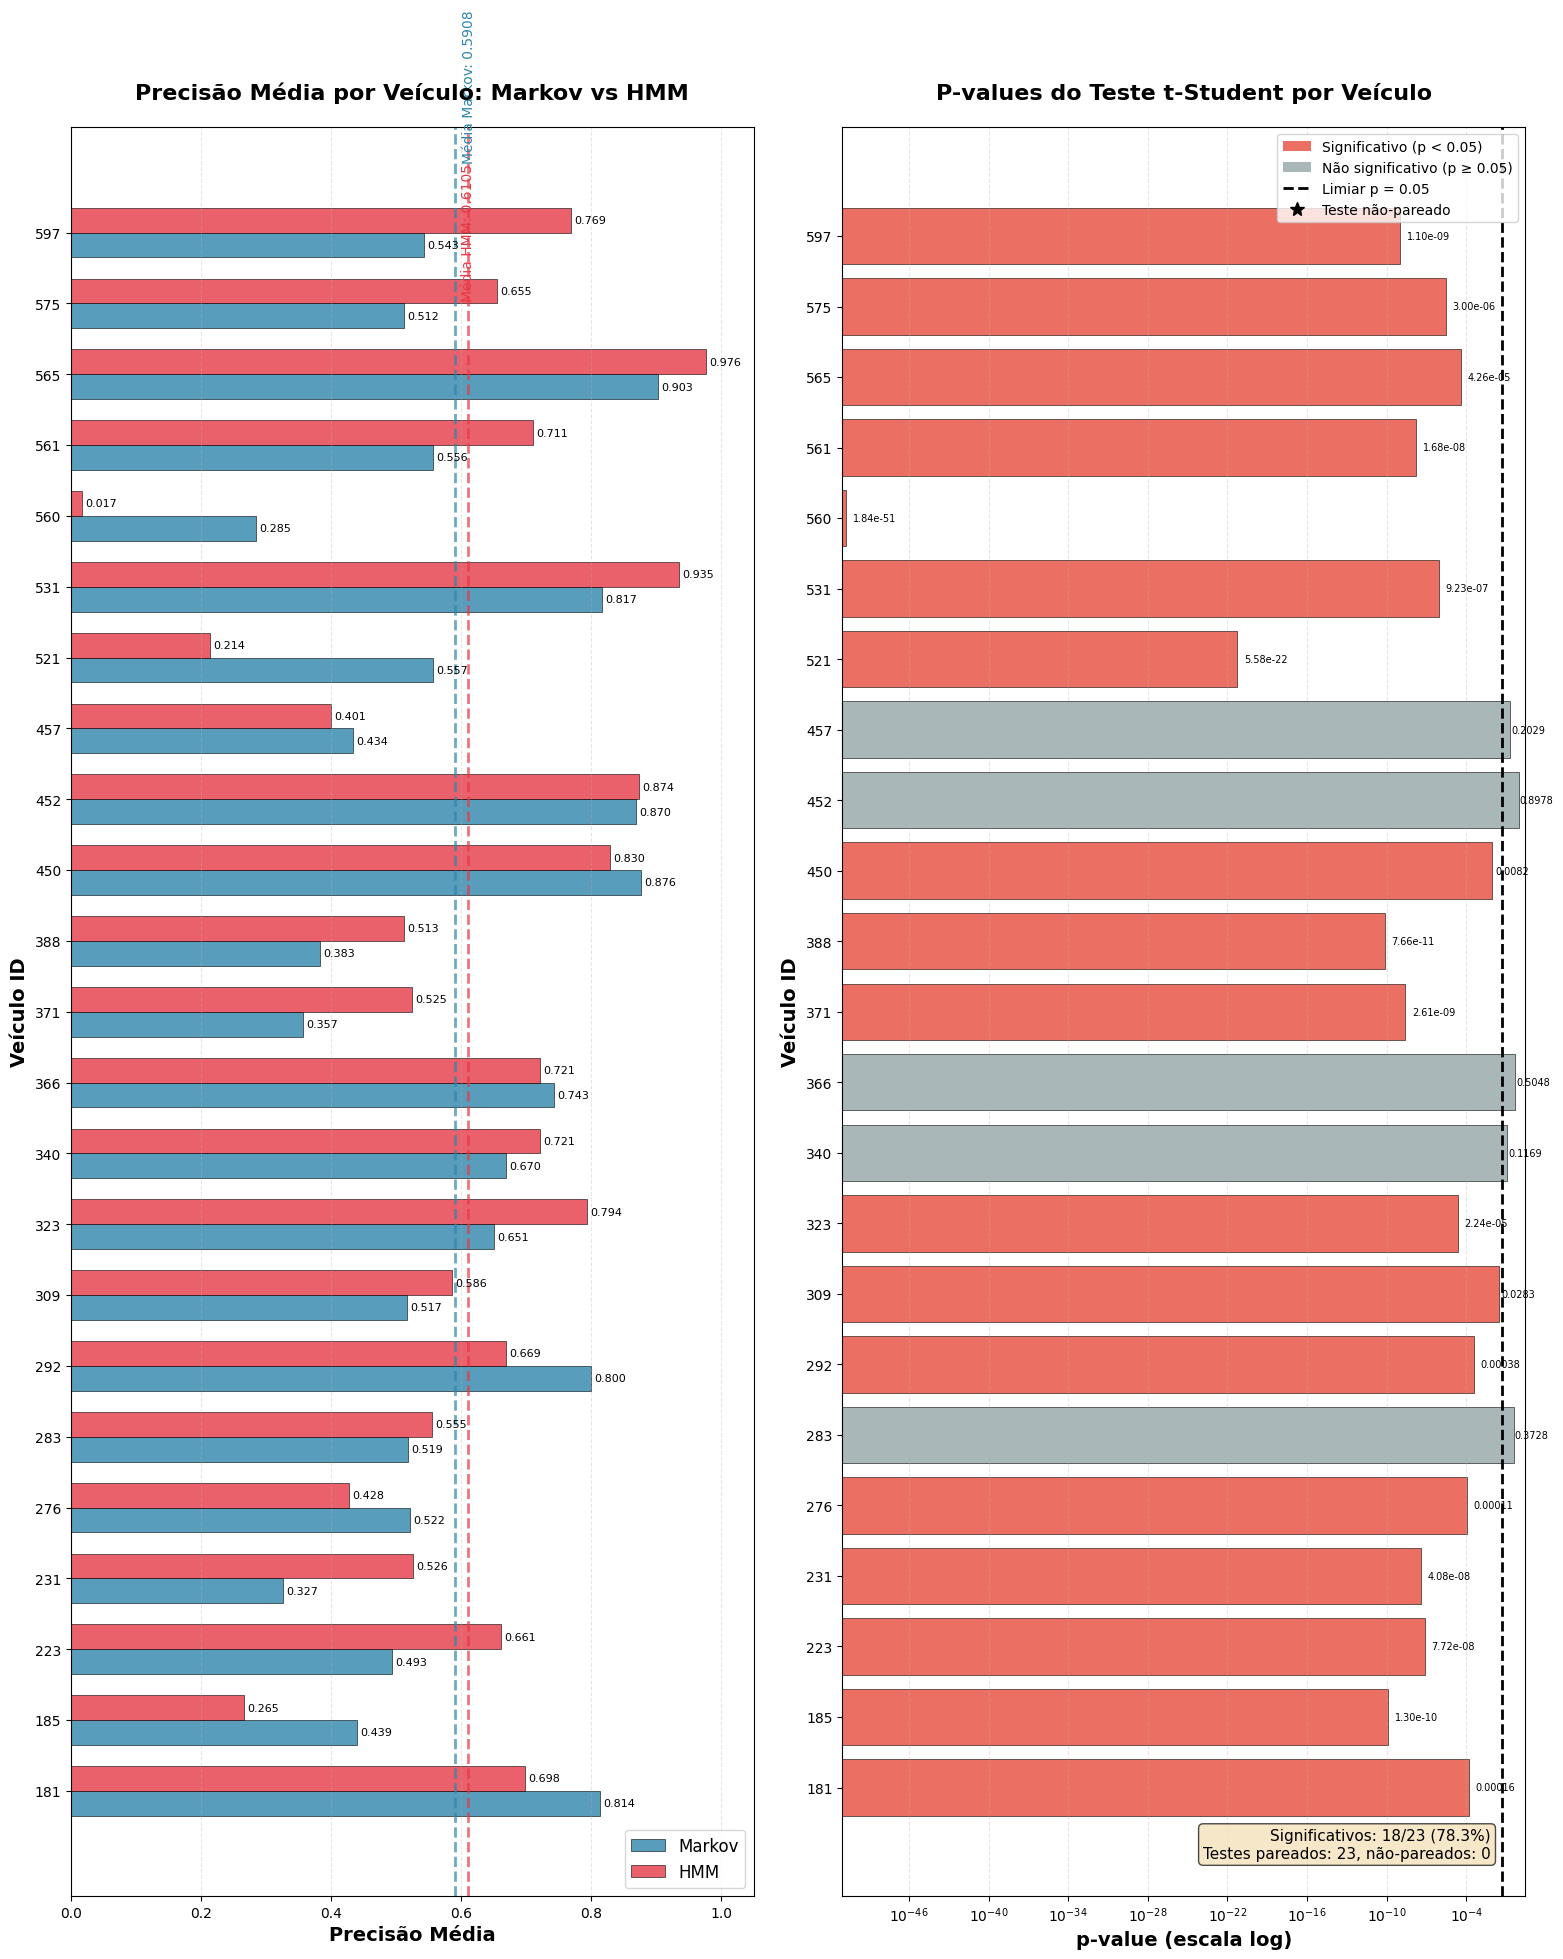


=== RESUMO ESTATÍSTICO ===
Número de veículos: 23
Média Markov: 0.590835
Média HMM: 0.610519
p-value global (teste pareado): 0.754401

--- Análise de Pareamento ---
Testes pareados realizados: 23
Testes não-pareados (fallback): 0

Veículos com diferença significativa (p < 0.05): 18 (78.3%)
Veículos sem diferença significativa: 5 (21.7%)

Veículos com p < 0.05: [181, 185, 223, 231, 276, 292, 309, 323, 371, 388, 450, 521, 531, 560, 561, 565, 575, 597]

✓ Resultados salvos em 'analise_markov_hmm_pareado.csv'


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Carregar dados
markov_df = pd.read_csv('markov.csv')
hmm_df = pd.read_csv('hmm.csv')

# Calcular médias por veículo para o teste global
markov_means = markov_df.groupby('vehicle_id')['precision'].mean().reset_index()
markov_means.columns = ['vehicle_id', 'mean_markov']

hmm_means = hmm_df.groupby('vehicle_id')['precision'].mean().reset_index()
hmm_means.columns = ['vehicle_id', 'mean_hmm']

# Merge e calcular diferenças
paired_data = markov_means.merge(hmm_means, on='vehicle_id', how='inner')
paired_data['difference'] = paired_data['mean_markov'] - paired_data['mean_hmm']

# Teste t-student pareado global
t_statistic, p_value_global = ttest_ind(paired_data['mean_markov'], paired_data['mean_hmm'])

# === Garantir pareamento correto ===
# Fazer merge garantindo correspondência de repeat e fold
markov_paired = markov_df[['vehicle_id', 'repeat', 'fold', 'precision']].copy()
markov_paired.columns = ['vehicle_id', 'repeat', 'fold', 'precision_markov']

hmm_paired = hmm_df[['vehicle_id', 'repeat', 'fold', 'precision']].copy()
hmm_paired.columns = ['vehicle_id', 'repeat', 'fold', 'precision_hmm']

# Merge por vehicle_id, repeat e fold para garantir pareamento
fully_paired = markov_paired.merge(hmm_paired,
                                  on=['vehicle_id', 'repeat', 'fold'],
                                  how='inner')

print(f"Total de pares encontrados: {len(fully_paired)}")
print(f"Veículos únicos: {fully_paired['vehicle_id'].nunique()}")

# Calcular p-values individuais por veículo com pareamento correto
p_values_per_vehicle = []
n_pairs_per_vehicle = []
test_used = []

for vehicle in paired_data['vehicle_id']:
    # Dados pareados para este veículo
    vehicle_paired = fully_paired[fully_paired['vehicle_id'] == vehicle]

    if len(vehicle_paired) > 1:
        # Temos dados pareados suficientes
        _, p_val_paired = ttest_ind(vehicle_paired['precision_markov'],
                                   vehicle_paired['precision_hmm'])
        p_values_per_vehicle.append(p_val_paired)
        n_pairs_per_vehicle.append(len(vehicle_paired))
        test_used.append('paired')
    else:
        # Usar teste não-pareado como fallback
        markov_vehicle = markov_df[markov_df['vehicle_id'] == vehicle]['precision'].values
        hmm_vehicle = hmm_df[hmm_df['vehicle_id'] == vehicle]['precision'].values

        if len(markov_vehicle) > 1 and len(hmm_vehicle) > 1:
            _, p_val_unpaired = ttest_ind(markov_vehicle, hmm_vehicle)
            p_values_per_vehicle.append(p_val_unpaired)
            n_pairs_per_vehicle.append(0)  # 0 indica teste não-pareado
            test_used.append('unpaired')
        else:
            p_values_per_vehicle.append(np.nan)
            n_pairs_per_vehicle.append(0)
            test_used.append('none')

paired_data['p_value'] = p_values_per_vehicle
paired_data['n_pairs'] = n_pairs_per_vehicle
paired_data['test_type'] = test_used

# Ordenar por vehicle_id para melhor visualização
paired_data = paired_data.sort_values('vehicle_id')

# Criar figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 20))

# === GRÁFICO 1: PRECISÕES POR VEÍCULO (BARRAS HORIZONTAIS) ===
y_positions = np.arange(len(paired_data))
height = 0.35

# Barras horizontais para Markov e HMM
bars1 = ax1.barh(y_positions - height/2, paired_data['mean_markov'], height,
                 label='Markov', color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = ax1.barh(y_positions + height/2, paired_data['mean_hmm'], height,
                 label='HMM', color='#E63946', alpha=0.8, edgecolor='black', linewidth=0.5)

# Adicionar valores nas barras
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    width1 = bar1.get_width()
    width2 = bar2.get_width()
    ax1.text(width1 + 0.005, bar1.get_y() + bar1.get_height()/2.,
             f'{width1:.3f}', ha='left', va='center', fontsize=8)
    ax1.text(width2 + 0.005, bar2.get_y() + bar2.get_height()/2.,
             f'{width2:.3f}', ha='left', va='center', fontsize=8)

# Configurações do gráfico 1
ax1.set_ylabel('Veículo ID', fontsize=14, fontweight='bold')
ax1.set_xlabel('Precisão Média', fontsize=14, fontweight='bold')
ax1.set_title('Precisão Média por Veículo: Markov vs HMM', fontsize=16, fontweight='bold', pad=20)
ax1.set_yticks(y_positions)
ax1.set_yticklabels(paired_data['vehicle_id'].astype(str))
ax1.legend(fontsize=12, loc='lower right')
ax1.grid(True, alpha=0.3, axis='x', linestyle='--')
ax1.set_xlim(0, 1.05)

# Adicionar linha de média global
mean_markov = paired_data['mean_markov'].mean()
mean_hmm = paired_data['mean_hmm'].mean()
ax1.axvline(x=mean_markov, color='#2E86AB', linestyle='--', linewidth=2, alpha=0.7)
ax1.axvline(x=mean_hmm, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)
ax1.text(mean_markov + 0.01, 0.98, f'Média Markov: {mean_markov:.4f}',
         transform=ax1.get_xaxis_transform(), fontsize=10, color='#2E86AB', rotation=90, va='bottom')
ax1.text(mean_hmm - 0.01, 0.98, f'Média HMM: {mean_hmm:.4f}',
         transform=ax1.get_xaxis_transform(), fontsize=10, color='#E63946', rotation=90, va='top')

# === GRÁFICO 2: P-VALUES POR VEÍCULO (BARRAS HORIZONTAIS) ===
# Definir cores baseadas na significância
colors = ['#E74C3C' if p < 0.05 else '#95A5A6' for p in paired_data['p_value']]

# Substituir valores NaN por 1.0 para visualização
p_values_plot = paired_data['p_value'].fillna(1.0)

bars_pval = ax2.barh(y_positions, p_values_plot, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Usar escala logarítmica
ax2.set_xscale('log')

# Linha de significância (p = 0.05)
ax2.axvline(x=0.05, color='black', linestyle='--', linewidth=2, label='p = 0.05')

# Adicionar indicadores de tipo de teste
for i, (bar, test_type) in enumerate(zip(bars_pval, paired_data['test_type'])):
    if test_type == 'unpaired':
        ax2.text(0.0001, bar.get_y() + bar.get_height()/2., '*',
                ha='center', va='center', fontsize=12, fontweight='bold')

# Adicionar valores de p-value nas barras
for i, (bar, p_val) in enumerate(zip(bars_pval, paired_data['p_value'])):
    if not np.isnan(p_val):
        # Formatar o texto baseado no valor
        if p_val < 0.0001:
            text = f'{p_val:.2e}'
        elif p_val < 0.001:
            text = f'{p_val:.5f}'
        else:
            text = f'{p_val:.4f}'

        # Posicionar o texto ao lado da barra
        text_x = bar.get_width() * 1.5
        text_y = bar.get_y() + bar.get_height()/2.

        # Ajustar posição X para valores muito pequenos
        if p_val < 0.001:
            text_x = p_val * 3
        elif p_val < 0.01:
            text_x = p_val * 2
        elif p_val < 0.1:
            text_x = p_val * 1.5
        else:
            text_x = p_val * 1.2

        ax2.text(text_x, text_y, text,
                ha='left', va='center', fontsize=7)

# Configurações do gráfico 2
ax2.set_ylabel('Veículo ID', fontsize=14, fontweight='bold')
ax2.set_xlabel('p-value (escala log)', fontsize=14, fontweight='bold')
ax2.set_title(f'P-values do Teste t-Student por Veículo',
              fontsize=16, fontweight='bold', pad=20)
ax2.set_yticks(y_positions)
ax2.set_yticklabels(paired_data['vehicle_id'].astype(str))
ax2.grid(True, alpha=0.3, axis='x', linestyle='--', which='both')

# Ajustar limites do eixo X para acomodar todos os textos
x_min = min(p_values_plot.min() * 0.5, 0.0001)
x_max = max(p_values_plot.max() * 3.0, 1.5)
ax2.set_xlim(x_min, x_max)

# Legenda personalizada
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#E74C3C', alpha=0.8, label='Significativo (p < 0.05)'),
    Patch(facecolor='#95A5A6', alpha=0.8, label='Não significativo (p ≥ 0.05)'),
    plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Limiar p = 0.05'),
    plt.Line2D([0], [0], marker='*', color='black', linestyle='', markersize=10, label='Teste não-pareado')
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Adicionar resumo estatístico
n_significant = sum(paired_data['p_value'] < 0.05)
n_total = len(paired_data)
n_paired_tests = sum(paired_data['test_type'] == 'paired')
info_text = (f"Significativos: {n_significant}/{n_total} ({n_significant/n_total*100:.1f}%)\n"
             f"Testes pareados: {n_paired_tests}, não-pareados: {n_total - n_paired_tests}")
ax2.text(0.95, 0.02, info_text, transform=ax2.transAxes, fontsize=11,
         verticalalignment='bottom', ha='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Ajustar layout
plt.tight_layout(pad=2.0)

# Salvar figura
plt.savefig('precisao_pvalues_markov_hmm_horizontal.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Imprimir resumo detalhado
print("\n=== RESUMO ESTATÍSTICO ===")
print(f"Número de veículos: {n_total}")
print(f"Média Markov: {mean_markov:.6f}")
print(f"Média HMM: {mean_hmm:.6f}")
print(f"p-value global (teste pareado): {p_value_global:.6f}")
print(f"\n--- Análise de Pareamento ---")
print(f"Testes pareados realizados: {n_paired_tests}")
print(f"Testes não-pareados (fallback): {n_total - n_paired_tests}")
print(f"\nVeículos com diferença significativa (p < 0.05): {n_significant} ({n_significant/n_total*100:.1f}%)")
print(f"Veículos sem diferença significativa: {n_total - n_significant} ({(n_total - n_significant)/n_total*100:.1f}%)")

# Listar veículos significativos
significant_vehicles = paired_data[paired_data['p_value'] < 0.05]['vehicle_id'].tolist()
if significant_vehicles:
    print(f"\nVeículos com p < 0.05: {significant_vehicles}")

# Salvar resultados detalhados
paired_data.to_csv('analise_markov_hmm_pareado.csv', index=False)
print("\n✓ Resultados salvos em 'analise_markov_hmm_pareado.csv'")

In [ ]:
paired_data.to_csv('paired_data.csv')

=== ANÁLISE P-VALUE GLOBAL ===
Total observações Markov: 2300
Total observações HMM: 2300
Média Markov (global): 0.590835
Média HMM (global): 0.610519
Desvio padrão Markov: 0.266074
Desvio padrão HMM: 0.314837
P-value global: 0.022088
T-statistic global: -2.289630
Significativo (p < 0.05): SIM


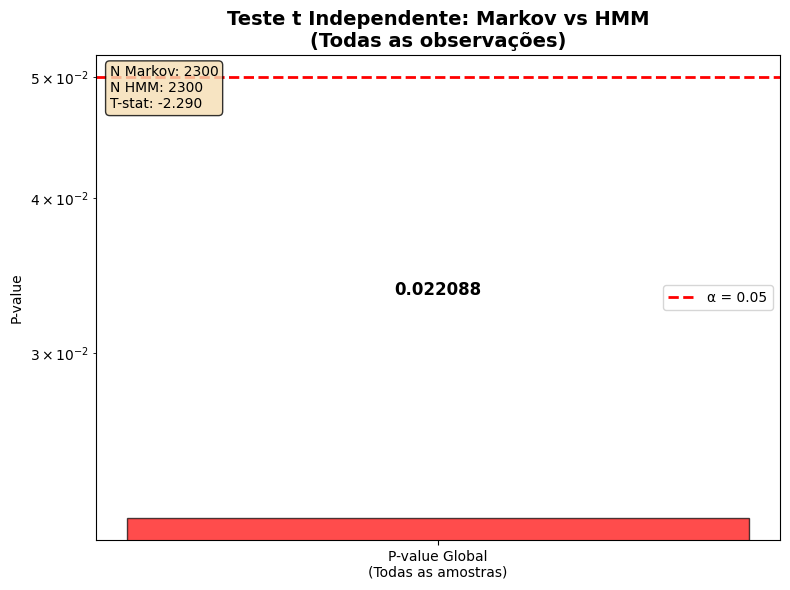


=== ESTATÍSTICAS DESCRITIVAS ===
Diferença das médias (Markov - HMM): -0.019684
Mediana Markov: 0.600000
Mediana HMM: 0.642857
Min Markov: 0.000000
Max Markov: 1.000000
Min HMM: 0.000000
Max HMM: 1.000000

✓ Análise p-value global concluída
✓ Resultado salvo em: 'resultado_pvalue_global.csv'
✓ Gráfico salvo em: 'pvalue_global_simples.png'


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Carregar dados
markov_df = pd.read_csv('markov.csv')
hmm_df = pd.read_csv('hmm.csv')

# P-VALUE GLOBAL: Usando TODAS as observações de ambos os datasets
all_markov = markov_df['precision'].values
all_hmm = hmm_df['precision'].values

# Teste global simples (não pareado)
t_global, p_global = ttest_ind(all_markov, all_hmm)

print(f"=== ANÁLISE P-VALUE GLOBAL ===")
print(f"Total observações Markov: {len(all_markov)}")
print(f"Total observações HMM: {len(all_hmm)}")
print(f"Média Markov (global): {all_markov.mean():.6f}")
print(f"Média HMM (global): {all_hmm.mean():.6f}")
print(f"Desvio padrão Markov: {all_markov.std():.6f}")
print(f"Desvio padrão HMM: {all_hmm.std():.6f}")
print(f"P-value global: {p_global:.6f}")
print(f"T-statistic global: {t_global:.6f}")
print(f"Significativo (p < 0.05): {'SIM' if p_global < 0.05 else 'NÃO'}")

# Visualização do p-value global
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Gráfico de barras simples
method = 'P-value Global\n(Todas as amostras)'
color = 'red' if p_global < 0.05 else 'gray'

bar = ax.bar([method], [p_global], color=color, alpha=0.7, edgecolor='black', width=0.5)
ax.axhline(0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax.set_ylabel('P-value')
ax.set_title('Teste t Independente: Markov vs HMM\n(Todas as observações)', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Adicionar valor na barra
height = bar[0].get_height()
ax.text(bar[0].get_x() + bar[0].get_width()/2., height*1.5,
         f'{p_global:.6f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Adicionar informações estatísticas no gráfico
info_text = f'N Markov: {len(all_markov)}\nN HMM: {len(all_hmm)}\nT-stat: {t_global:.3f}'
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('pvalue_global_simples.png', dpi=300, bbox_inches='tight')
plt.show()

# Estatísticas descritivas adicionais
print(f"\n=== ESTATÍSTICAS DESCRITIVAS ===")
print(f"Diferença das médias (Markov - HMM): {all_markov.mean() - all_hmm.mean():.6f}")
print(f"Mediana Markov: {np.median(all_markov):.6f}")
print(f"Mediana HMM: {np.median(all_hmm):.6f}")
print(f"Min Markov: {all_markov.min():.6f}")
print(f"Max Markov: {all_markov.max():.6f}")
print(f"Min HMM: {all_hmm.min():.6f}")
print(f"Max HMM: {all_hmm.max():.6f}")

# Salvar resultados
results_global = {
    'metrica': ['n_observacoes_markov', 'n_observacoes_hmm', 'media_markov', 'media_hmm',
               'desvio_markov', 'desvio_hmm', 'diferenca_medias', 't_statistic', 'p_value', 'significativo'],
    'valor': [len(all_markov), len(all_hmm), all_markov.mean(), all_hmm.mean(),
             all_markov.std(), all_hmm.std(), all_markov.mean() - all_hmm.mean(),
             t_global, p_global, p_global < 0.05]
}

results_df = pd.DataFrame(results_global)
results_df.to_csv('resultado_pvalue_global.csv', index=False)

print(f"\n✓ Análise p-value global concluída")
print("✓ Resultado salvo em: 'resultado_pvalue_global.csv'")
print("✓ Gráfico salvo em: 'pvalue_global_simples.png'")

In [ ]:
markov_df

,Unnamed: 0.1,Unnamed: 0,vehicle_id,repeat,fold,precision,best_alpha
0,0,0,181,0,0,0.791667,0.001
1,1,1,181,0,1,0.805556,0.001
2,2,2,181,0,2,0.800000,0.001
3,3,3,181,0,3,0.791667,0.001
4,4,4,181,0,4,0.770833,0.001
...,...,...,...,...,...,...,...
2295,2295,2295,597,9,5,0.250000,0.001
2296,2296,2296,597,9,6,0.250000,0.001
2297,2297,2297,597,9,7,1.000000,0.001
2298,2298,2298,597,9,8,0.694444,0.001


In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=41d76bc6a8d6bdd577aee8af0f63f9405d6e0cc15e11e6229e592e5748b640ea
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


**GERADOR DE RELATÓRIOS**

In [ ]:
################### SCRIPT COMPLETO DE RELATÓRIOS - MARKOV E HMM COM PYDTMC ###################

import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from datetime import datetime
from fpdf import FPDF
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("SISTEMA DE GERAÇÃO DE RELATÓRIOS - MARKOV vs HMM")
print("="*80)
print("\nATENÇÃO: Este script gera relatórios de demonstração que mostram")
print("o funcionamento dos modelos Markov e HMM usando PyDTMC.")
print("\nOs relatórios gerados incluem:")
print("- Análise detalhada de TODOS os veículos dos resultados oficiais")
print("- Demonstrações de predições para alguns veículos selecionados")
print("- Comparações entre precisões oficiais e demonstrativas")
print("\nAs predições demonstrativas podem diferir dos resultados oficiais")
print("pois usam menos folds (3 em vez de 10) para economia de tempo.")
print("="*80)
print("\nPressione Enter para continuar...")
input()

# Verificar importação do pydtmc
try:
    import pydtmc
    print(f"\nPyDTMC versão: {pydtmc.__version__ if hasattr(pydtmc, '__version__') else 'versão não disponível'}")
except ImportError as e:
    print(f"Erro ao importar PyDTMC: {e}")
    raise

# Função auxiliar para tratar texto para PDF
def clean_text_for_pdf(text):
    """Limpa texto para compatibilidade com PDF"""
    char_replacements = {
        'ã': 'a', 'á': 'a', 'à': 'a', 'â': 'a', 'ä': 'a',
        'é': 'e', 'ê': 'e', 'è': 'e', 'ë': 'e',
        'í': 'i', 'î': 'i', 'ì': 'i', 'ï': 'i',
        'õ': 'o', 'ó': 'o', 'ô': 'o', 'ò': 'o', 'ö': 'o',
        'ú': 'u', 'û': 'u', 'ù': 'u', 'ü': 'u',
        'ç': 'c', 'ñ': 'n',
        'Ã': 'A', 'Á': 'A', 'À': 'A', 'Â': 'A', 'Ä': 'A',
        'É': 'E', 'Ê': 'E', 'È': 'E', 'Ë': 'E',
        'Í': 'I', 'Î': 'I', 'Ì': 'I', 'Ï': 'I',
        'Õ': 'O', 'Ó': 'O', 'Ô': 'O', 'Ò': 'O', 'Ö': 'O',
        'Ú': 'U', 'Û': 'U', 'Ù': 'U', 'Ü': 'U',
        'Ç': 'C', 'Ñ': 'N'
    }

    for char, replacement in char_replacements.items():
        text = text.replace(char, replacement)

    text = ''.join(c if ord(c) >= 32 and ord(c) < 127 else ' ' for c in text)
    return text

# Função auxiliar para adicionar texto ao PDF
def add_text_to_pdf(pdf, text, font_size=8, bold=False):
    """Adiciona texto ao PDF com quebra automática de linha"""
    font_style = 'B' if bold else ''
    pdf.set_font("Courier", font_style, size=font_size)

    if pdf.get_y() > 270:
        pdf.add_page()

    text = clean_text_for_pdf(str(text))
    max_chars = 120

    if len(text) <= max_chars:
        pdf.cell(0, 5, txt=text, ln=1)
    else:
        words = text.split(' ')
        current_line = ""

        for word in words:
            if len(current_line + " " + word) <= max_chars:
                current_line += (" " + word) if current_line else word
            else:
                if current_line:
                    pdf.cell(0, 5, txt=current_line, ln=1)
                    current_line = word
                else:
                    while len(word) > max_chars:
                        pdf.cell(0, 5, txt=word[:max_chars], ln=1)
                        word = word[max_chars:]
                    current_line = word

        if current_line:
            pdf.cell(0, 5, txt=current_line, ln=1)

# Função para calcular predições Markov usando PyDTMC
def calculate_markov_predictions_pydtmc(vehicle_trips, origem_col, destino_col, alpha=0.001, n_folds=3):
    """Calcula predições Markov usando PyDTMC"""
    if len(vehicle_trips) < 10:
        return []

    results = []
    fold_size = max(1, len(vehicle_trips) // n_folds)

    for fold in range(min(n_folds, len(vehicle_trips))):
        test_start = fold * fold_size
        test_end = min(test_start + fold_size, len(vehicle_trips))

        test_indices = list(range(test_start, test_end))
        train_indices = [i for i in range(len(vehicle_trips)) if i not in test_indices]

        if len(train_indices) < 5 or len(test_indices) < 2:
            continue

        train_data = vehicle_trips.iloc[train_indices]
        test_data = vehicle_trips.iloc[test_indices]

        try:
            # Coletar estados únicos
            all_states = sorted(list(set(
                train_data[origem_col].astype(str).tolist() +
                train_data[destino_col].astype(str).tolist()
            )))

            if len(all_states) < 2:
                continue

            # Construir matriz de transição com pseudocontagem
            transition_counts = defaultdict(lambda: defaultdict(float))

            # Adicionar pseudocontagem alpha
            for state1 in all_states:
                for state2 in all_states:
                    transition_counts[state1][state2] = alpha

            # Contar transições
            for i in range(len(train_data)):
                origem = str(train_data.iloc[i][origem_col])
                destino = str(train_data.iloc[i][destino_col])
                transition_counts[origem][destino] += 1

            # Criar matriz de transição normalizada
            p_matrix = np.zeros((len(all_states), len(all_states)))
            state_to_idx = {state: i for i, state in enumerate(all_states)}

            for i, state1 in enumerate(all_states):
                row_sum = sum(transition_counts[state1].values())
                for j, state2 in enumerate(all_states):
                    p_matrix[i, j] = transition_counts[state1][state2] / row_sum

            # Criar cadeia de Markov com PyDTMC
            mc = pydtmc.MarkovChain(p_matrix, states=all_states)

            # Fazer predições
            predictions = []
            y_true = []
            y_pred = []

            for i in range(len(test_data)):
                origem = str(test_data.iloc[i][origem_col])
                real_destino = str(test_data.iloc[i][destino_col])

                if origem in all_states and real_destino in all_states:
                    # Predição determinística usando matriz de transição
                    origem_idx = state_to_idx[origem]
                    transition_probs = p_matrix[origem_idx, :]
                    pred_idx = np.argmax(transition_probs)
                    pred_destino = all_states[pred_idx]

                    y_true.append(real_destino)
                    y_pred.append(pred_destino)

                    predictions.append({
                        'origem': origem,
                        'real': real_destino,
                        'predito': pred_destino,
                        'acerto': pred_destino == real_destino
                    })
                else:
                    # Estado não visto no treino
                    pred_destino = "UNKNOWN"
                    predictions.append({
                        'origem': origem,
                        'real': real_destino,
                        'predito': pred_destino,
                        'acerto': False
                    })

            # Calcular métricas
            if len(predictions) > 0:
                n_acertos = sum(p['acerto'] for p in predictions)
                n_erros = len(predictions) - n_acertos

                results.append({
                    'fold': fold + 1,
                    'n_train': len(train_data),
                    'n_test': len(test_data),
                    'predictions': predictions,
                    'n_acertos': n_acertos,
                    'n_erros': n_erros
                })

        except Exception as e:
            print(f"Erro no fold {fold + 1}: {e}")
            continue

    return results

# Função para calcular predições HMM usando PyDTMC
def calculate_hmm_predictions_pydtmc(vehicle_trips, origem_col, destino_col, dia_col, alpha=0.001, n_folds=3):
    """Calcula predições HMM usando PyDTMC com Viterbi"""
    if len(vehicle_trips) < 10:
        return []

    results = []
    fold_size = max(1, len(vehicle_trips) // n_folds)

    for fold in range(min(n_folds, len(vehicle_trips))):
        test_start = fold * fold_size
        test_end = min(test_start + fold_size, len(vehicle_trips))

        test_indices = list(range(test_start, test_end))
        train_indices = [i for i in range(len(vehicle_trips)) if i not in test_indices]

        if len(train_indices) < 5 or len(test_indices) < 2:
            continue

        train_data = vehicle_trips.iloc[train_indices].copy()
        test_data = vehicle_trips.iloc[test_indices].copy()

        try:
            # Estados ocultos (destinos)
            vehicle_states = sorted(list(set(
                train_data[destino_col].astype(str).tolist()
            )))

            if len(vehicle_states) < 2:
                continue

            # Criar símbolos observáveis (dia + origem)
            train_data['simbolo'] = train_data.apply(
                lambda row: f"dia:{row[dia_col]}_grid:{row[origem_col]}",
                axis=1
            )
            test_data['simbolo'] = test_data.apply(
                lambda row: f"dia:{row[dia_col]}_grid:{row[origem_col]}",
                axis=1
            )

            vehicle_symbols = sorted(train_data['simbolo'].unique())

            # Construir matrizes HMM com pseudocontagem
            transition_counts = defaultdict(lambda: defaultdict(float))
            emission_counts = defaultdict(lambda: defaultdict(float))

            # Adicionar pseudocontagem alpha
            for state1 in vehicle_states:
                for state2 in vehicle_states:
                    transition_counts[state1][state2] = alpha
                for symbol in vehicle_symbols:
                    emission_counts[state1][symbol] = alpha

            # Contabilizar transições entre estados ocultos
            for i in range(len(train_data) - 1):
                current_state = str(train_data.iloc[i][destino_col])
                next_state = str(train_data.iloc[i + 1][destino_col])
                transition_counts[current_state][next_state] += 1

            # Contabilizar emissões
            for i in range(len(train_data)):
                state = str(train_data.iloc[i][destino_col])
                observation = train_data.iloc[i]['simbolo']
                emission_counts[state][observation] += 1

            # Criar matrizes normalizadas
            p_matrix = np.zeros((len(vehicle_states), len(vehicle_states)))
            e_matrix = np.zeros((len(vehicle_states), len(vehicle_symbols)))

            state_to_idx = {state: i for i, state in enumerate(vehicle_states)}
            symbol_to_idx = {symbol: i for i, symbol in enumerate(vehicle_symbols)}

            # Normalizar matriz de transição
            for i, state1 in enumerate(vehicle_states):
                row_sum = sum(transition_counts[state1].values())
                for j, state2 in enumerate(vehicle_states):
                    p_matrix[i, j] = transition_counts[state1][state2] / row_sum

            # Normalizar matriz de emissão
            for i, state in enumerate(vehicle_states):
                row_sum = sum(emission_counts[state].values())
                for j, symbol in enumerate(vehicle_symbols):
                    e_matrix[i, j] = emission_counts[state][symbol] / row_sum

            # Criar HMM com PyDTMC
            hmm = pydtmc.HiddenMarkovModel(
                p=p_matrix,
                e=e_matrix,
                states=vehicle_states,
                symbols=vehicle_symbols
            )

            # Fazer predições
            predictions = []
            y_true = []
            y_pred = []

            for idx in range(len(test_data)):
                observacao_atual = test_data.iloc[idx]['simbolo']
                estado_real = str(test_data.iloc[idx][destino_col])

                if observacao_atual in vehicle_symbols and estado_real in vehicle_states:
                    try:
                        # Usar Viterbi para decodificar
                        initial_dist = np.ones(len(vehicle_states)) / len(vehicle_states)

                        predicted_result = hmm.predict(
                            prediction_type='viterbi',
                            symbols=[observacao_atual],
                            initial_status=initial_dist,
                            output_indices=False
                        )

                        if predicted_result is not None:
                            log_prob, states_path = predicted_result
                            estado_predito = states_path[-1]
                        else:
                            # Fallback: estado mais provável dada a observação
                            obs_idx = symbol_to_idx[observacao_atual]
                            emission_probs = e_matrix[:, obs_idx]
                            estado_predito = vehicle_states[np.argmax(emission_probs)]

                        y_true.append(estado_real)
                        y_pred.append(estado_predito)

                        predictions.append({
                            'observacao': observacao_atual,
                            'real': estado_real,
                            'predito': estado_predito,
                            'acerto': estado_predito == estado_real
                        })

                    except Exception as e:
                        # Observação não vista - usar fallback
                        predictions.append({
                            'observacao': observacao_atual,
                            'real': estado_real,
                            'predito': "UNKNOWN",
                            'acerto': False
                        })
                else:
                    predictions.append({
                        'observacao': observacao_atual if observacao_atual in vehicle_symbols else "UNKNOWN",
                        'real': estado_real,
                        'predito': "UNKNOWN",
                        'acerto': False
                    })

            # Calcular métricas
            if len(predictions) > 0:
                n_acertos = sum(p['acerto'] for p in predictions)
                n_erros = len(predictions) - n_acertos

                results.append({
                    'fold': fold + 1,
                    'n_train': len(train_data),
                    'n_test': len(test_data),
                    'predictions': predictions,
                    'n_acertos': n_acertos,
                    'n_erros': n_erros
                })

        except Exception as e:
            print(f"Erro no fold {fold + 1}: {e}")
            import traceback
            traceback.print_exc()
            continue

    return results

# Função para gerar relatório Markov
def generate_markov_report(df_trips, results_markov_df, output_file='relatorio_markov_pydtmc.pdf'):
    """Gera relatório detalhado Markov com PyDTMC"""
    print("\n=== Gerando Relatório Markov ===")

    pdf = FPDF(format='A4')
    pdf.add_page()

    # Cabeçalho
    add_text_to_pdf(pdf, "="*70, 12, True)
    add_text_to_pdf(pdf, "RELATORIO MARKOV - ANALISE COM PyDTMC", 12, True)
    add_text_to_pdf(pdf, "="*70, 12, True)
    add_text_to_pdf(pdf, f"Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    add_text_to_pdf(pdf, "")

    # AVISO IMPORTANTE
    add_text_to_pdf(pdf, "IMPORTANTE: Este relatorio apresenta demonstracoes do funcionamento", 10, True)
    add_text_to_pdf(pdf, "do modelo Markov usando PyDTMC. As predicoes demonstrativas usam", 10)
    add_text_to_pdf(pdf, "apenas 3 folds para economia de tempo, enquanto os resultados", 10)
    add_text_to_pdf(pdf, "oficiais usam 10 folds com 5 repeticoes. Por isso, pode haver", 10)
    add_text_to_pdf(pdf, "diferencas entre a precisao oficial e a demonstrativa.", 10)
    add_text_to_pdf(pdf, "")

    # Estatísticas gerais
    vehicles = results_markov_df['vehicle_id'].unique()
    n_vehicles = len(vehicles)
    n_repeats = results_markov_df['repeat'].nunique() if 'repeat' in results_markov_df.columns else 1

    add_text_to_pdf(pdf, "=== RESUMO GERAL ===", bold=True)
    add_text_to_pdf(pdf, f"Total de veiculos: {n_vehicles}")
    add_text_to_pdf(pdf, f"Numero de repeticoes: {n_repeats}")
    add_text_to_pdf(pdf, f"Total de registros Markov: {len(results_markov_df)}")
    add_text_to_pdf(pdf, "")

    # Precisão global
    global_mean = results_markov_df['precision'].mean()
    global_std = results_markov_df['precision'].std()
    add_text_to_pdf(pdf, f"Precisao media global (resultados oficiais): {global_mean:.4f} +/- {global_std:.4f}")
    add_text_to_pdf(pdf, "")

    # Processar TODOS os veículos
    for vehicle_id in sorted(vehicles):
        vehicle_trips = df_trips[df_trips['Veículo'] == vehicle_id]
        vehicle_results = results_markov_df[results_markov_df['vehicle_id'] == vehicle_id]

        if len(vehicle_trips) == 0:
            continue

        add_text_to_pdf(pdf, "="*60)
        add_text_to_pdf(pdf, f"VEICULO: {vehicle_id}", bold=True)
        add_text_to_pdf(pdf, "="*60)
        add_text_to_pdf(pdf, f"Total de rotas: {len(vehicle_trips)}")
        add_text_to_pdf(pdf, f"Repeticoes executadas: {len(vehicle_results)}")

        # Precisão do veículo
        vehicle_mean = vehicle_results['precision'].mean()
        vehicle_std = vehicle_results['precision'].std()
        add_text_to_pdf(pdf, f"Precisao media (oficial): {vehicle_mean:.4f} +/- {vehicle_std:.4f}")

        # Melhor alpha
        if 'best_alpha' in vehicle_results.columns:
            best_alpha = vehicle_results['best_alpha'].mode()[0] if len(vehicle_results) > 0 else 0.001
            add_text_to_pdf(pdf, f"Melhor alpha (mais frequente): {best_alpha}")

        # Origens e destinos únicos
        origins = vehicle_trips['grid_origem'].unique()
        destinations = vehicle_trips['grid_destino'].unique()
        add_text_to_pdf(pdf, f"Origens unicas: {len(origins)}")
        add_text_to_pdf(pdf, f"Destinos unicos: {len(destinations)}")

        # Mostrar dados de treino
        add_text_to_pdf(pdf, "")
        add_text_to_pdf(pdf, "DADOS DE TREINO (origens e destinos):")
        for i in range(min(3, len(vehicle_trips))):
            origem = vehicle_trips.iloc[i]['grid_origem']
            destino = vehicle_trips.iloc[i]['grid_destino']
            add_text_to_pdf(pdf, f" Rota {i+1}: Origem {origem} -> Destino {destino}")

        # Calcular predições demonstrativas
        add_text_to_pdf(pdf, "")
        add_text_to_pdf(pdf, "ANALISE DE PREDICOES (DEMONSTRACAO COM PyDTMC):", bold=True)

        fold_results = calculate_markov_predictions_pydtmc(
            vehicle_trips, 'grid_origem', 'grid_destino', alpha=0.001, n_folds=3
        )

        if fold_results:
            total_acertos = sum(r['n_acertos'] for r in fold_results)
            total_erros = sum(r['n_erros'] for r in fold_results)
            total_testes = total_acertos + total_erros

            add_text_to_pdf(pdf, f"Total geral: {total_acertos} ACERTOS, {total_erros} ERROS")
            add_text_to_pdf(pdf, f"Precisao calculada (demonstracao): {total_acertos/total_testes:.4f}" if total_testes > 0 else "N/A")

            # Mostrar detalhes de até 2 folds
            for fold_result in fold_results[:2]:
                add_text_to_pdf(pdf, "")
                add_text_to_pdf(pdf, f"Fold {fold_result['fold']}:")
                add_text_to_pdf(pdf, f" Treino: {fold_result['n_train']} rotas")
                add_text_to_pdf(pdf, f" Teste: {fold_result['n_test']} rotas")
                add_text_to_pdf(pdf, f" Resultado: {fold_result['n_acertos']} ACERTOS, {fold_result['n_erros']} ERROS")

                # Mostrar algumas predições
                add_text_to_pdf(pdf, " Exemplos de teste (apenas destinos):")
                for j, pred in enumerate(fold_result['predictions'][:3]):
                    resultado = "ACERTO" if pred['acerto'] else "ERRO"
                    add_text_to_pdf(pdf, f"  Teste {j+1}: Predito={pred['predito']}, Real={pred['real']} -> {resultado}")

        add_text_to_pdf(pdf, "")

        # Verificar se precisa nova página
        if pdf.get_y() > 240:
            pdf.add_page()

    # Salvar PDF
    pdf.output(output_file)
    print(f"Relatório Markov salvo: {output_file}")

# Função para gerar relatório HMM
def generate_hmm_report(df_trips, results_hmm_df, output_file='relatorio_hmm_pydtmc.pdf'):
    """Gera relatório detalhado HMM com PyDTMC"""
    print("\n=== Gerando Relatório HMM ===")

    pdf = FPDF(format='A4')
    pdf.add_page()

    # Cabeçalho
    add_text_to_pdf(pdf, "="*70, 12, True)
    add_text_to_pdf(pdf, "RELATORIO HMM - ANALISE COM PyDTMC", 12, True)
    add_text_to_pdf(pdf, "="*70, 12, True)
    add_text_to_pdf(pdf, f"Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    add_text_to_pdf(pdf, "")

    # AVISO IMPORTANTE
    add_text_to_pdf(pdf, "IMPORTANTE: Este relatorio apresenta demonstracoes do funcionamento", 10, True)
    add_text_to_pdf(pdf, "do modelo HMM usando PyDTMC com algoritmo Viterbi. As predicoes", 10)
    add_text_to_pdf(pdf, "demonstrativas usam apenas 3 folds, enquanto os resultados", 10)
    add_text_to_pdf(pdf, "oficiais usam 10 folds com 5 repeticoes. Os valores de precisao", 10)
    add_text_to_pdf(pdf, "demonstrativa podem diferir significativamente dos oficiais.", 10)
    add_text_to_pdf(pdf, "")

    # Estatísticas gerais
    vehicles = results_hmm_df['vehicle_id'].unique()
    n_vehicles = len(vehicles)
    n_repeats = results_hmm_df['repeat'].nunique() if 'repeat' in results_hmm_df.columns else 1

    add_text_to_pdf(pdf, "=== RESUMO GERAL ===", bold=True)
    add_text_to_pdf(pdf, f"Total de veiculos: {n_vehicles}")
    add_text_to_pdf(pdf, f"Numero de repeticoes: {n_repeats}")
    add_text_to_pdf(pdf, f"Total de registros HMM: {len(results_hmm_df)}")
    add_text_to_pdf(pdf, "")

    # Processar TODOS os veículos
    for vehicle_id in sorted(vehicles):
        vehicle_trips = df_trips[df_trips['Veículo'] == vehicle_id]
        vehicle_results = results_hmm_df[results_hmm_df['vehicle_id'] == vehicle_id]

        if len(vehicle_trips) == 0:
            continue

        add_text_to_pdf(pdf, "="*60)
        add_text_to_pdf(pdf, f"VEICULO: {vehicle_id}", bold=True)
        add_text_to_pdf(pdf, "="*60)
        add_text_to_pdf(pdf, f"Total de rotas: {len(vehicle_trips)}")

        # Calcular melhor configuração por repetição
        best_by_repeat = []
        for repeat in sorted(vehicle_results['repeat'].unique()):
            repeat_data = vehicle_results[vehicle_results['repeat'] == repeat]
            best_idx = repeat_data['precision'].idxmax()
            best_row = repeat_data.loc[best_idx]
            best_by_repeat.append({
                'repeat': repeat,
                'precision': best_row['precision'],
                'alpha': best_row.get('alpha', 0.001)
            })

        # Calcular média das melhores precisões
        best_precisions = [b['precision'] for b in best_by_repeat]
        hmm_mean = np.mean(best_precisions)
        hmm_std = np.std(best_precisions)

        add_text_to_pdf(pdf, f"Precisao media oficial (melhor config/repeat): {hmm_mean:.4f} +/- {hmm_std:.4f}")

        # Configurações mais frequentes
        alphas = [b['alpha'] for b in best_by_repeat]
        best_alpha = max(set(alphas), key=alphas.count)
        add_text_to_pdf(pdf, f"Melhor alpha (mais frequente): {best_alpha}")

        # Informações sobre os dados
        origins = vehicle_trips['grid_origem'].unique()
        destinations = vehicle_trips['grid_destino'].unique()
        days = vehicle_trips['dia'].unique()

        add_text_to_pdf(pdf, f"Origens unicas: {len(origins)}")
        add_text_to_pdf(pdf, f"Destinos unicos (estados ocultos): {len(destinations)}")
        add_text_to_pdf(pdf, f"Dias unicos: {len(days)}")

        # Mostrar dados de treino
        add_text_to_pdf(pdf, "")
        add_text_to_pdf(pdf, "DADOS DE TREINO (dia, origem e destino):")
        for i in range(min(3, len(vehicle_trips))):
            dia = vehicle_trips.iloc[i]['dia']
            origem = vehicle_trips.iloc[i]['grid_origem']
            destino = vehicle_trips.iloc[i]['grid_destino']
            add_text_to_pdf(pdf, f" Emissao {i+1}: Dia={dia}, Origem={origem} -> Destino={destino}")

        # Calcular predições demonstrativas
        add_text_to_pdf(pdf, "")
        add_text_to_pdf(pdf, "ANALISE DE PREDICOES (DEMONSTRACAO COM PyDTMC - VITERBI):", bold=True)

        fold_results = calculate_hmm_predictions_pydtmc(
            vehicle_trips, 'grid_origem', 'grid_destino', 'dia', alpha=0.001, n_folds=3
        )

        if fold_results:
            total_acertos = sum(r['n_acertos'] for r in fold_results)
            total_erros = sum(r['n_erros'] for r in fold_results)
            total_testes = total_acertos + total_erros

            add_text_to_pdf(pdf, f"Total geral: {total_acertos} ACERTOS, {total_erros} ERROS")
            add_text_to_pdf(pdf, f"Precisao calculada (demonstracao): {total_acertos/total_testes:.4f}" if total_testes > 0 else "N/A")

            # Mostrar detalhes de até 2 folds
            for fold_result in fold_results[:2]:
                add_text_to_pdf(pdf, "")
                add_text_to_pdf(pdf, f"Fold {fold_result['fold']}:")
                add_text_to_pdf(pdf, f" Treino: {fold_result['n_train']} rotas")
                add_text_to_pdf(pdf, f" Teste: {fold_result['n_test']} rotas")
                add_text_to_pdf(pdf, f" Resultado: {fold_result['n_acertos']} ACERTOS, {fold_result['n_erros']} ERROS")

                # Mostrar algumas predições
                add_text_to_pdf(pdf, " Exemplos de teste (apenas destinos):")
                for j, pred in enumerate(fold_result['predictions'][:3]):
                    resultado = "ACERTO" if pred['acerto'] else "ERRO"
                    add_text_to_pdf(pdf, f"  Teste {j+1}: Predito={pred['predito']}, Real={pred['real']} -> {resultado}")

        add_text_to_pdf(pdf, "")

        # Verificar se precisa nova página
        if pdf.get_y() > 240:
            pdf.add_page()

    # Salvar PDF
    pdf.output(output_file)
    print(f"Relatório HMM salvo: {output_file}")

# Função principal
def main():
    """Função principal que gera todos os relatórios"""
    print("\n" + "="*80)
    print("PROCESSAMENTO INICIADO")
    print("="*80)

    try:
        # Carregar dados
        print("\n1. Carregando dados...")

        # Carregar os arquivos
        df = pd.read_csv('definitivo-oficial-fase2-limiar50(2).csv')
        print(f"   - Dados de trips carregados: {len(df)} registros")

        # Garantir que as colunas sejam strings
        df['grid_origem'] = df['grid_origem'].astype(str)
        df['grid_destino'] = df['grid_destino'].astype(str)
        df['dia'] = df['dia'].astype(str)
        df['Veículo'] = df['Veículo'].astype(str)

        results_markov_df = pd.read_csv('markov.csv')
        print(f"   - Resultados Markov carregados: {len(results_markov_df)} registros")
        results_markov_df['vehicle_id'] = results_markov_df['vehicle_id'].astype(str)

        results_hmm_df = pd.read_csv('hmm.csv')
        print(f"   - Resultados HMM carregados: {len(results_hmm_df)} registros")
        results_hmm_df['vehicle_id'] = results_hmm_df['vehicle_id'].astype(str)

        # Verificar dados
        print("\n2. Verificando dados...")
        print(f"   - Veículos únicos em trips: {df['Veículo'].nunique()}")
        print(f"   - Veículos únicos em Markov: {results_markov_df['vehicle_id'].nunique()}")
        print(f"   - Veículos únicos em HMM: {results_hmm_df['vehicle_id'].nunique()}")

        # Gerar relatórios
        print("\n3. Gerando relatórios...")
        print("   NOTA: Os relatórios incluem análise de TODOS os veículos.")
        print("   As demonstrações de predições usam apenas 3 folds por economia de tempo.")

        # Relatório Markov
        generate_markov_report(df, results_markov_df)

        # Relatório HMM
        generate_hmm_report(df, results_hmm_df)

        print("\n" + "="*80)
        print("PROCESSAMENTO CONCLUÍDO COM SUCESSO!")
        print("="*80)
        print("\nRelatórios gerados:")
        print("  1. relatorio_markov_pydtmc.pdf")
        print("  2. relatorio_hmm_pydtmc.pdf")
        print("\nOs relatórios incluem:")
        print("  - Análise de TODOS os veículos dos resultados oficiais")
        print("  - Demonstrações de predições usando PyDTMC")
        print("  - Comparação entre precisões oficiais e demonstrativas")
        print("\nATENÇÃO: As precisões demonstrativas podem diferir das oficiais")
        print("devido ao uso de menos folds (3 vs 10) para economia de tempo.")

    except Exception as e:
        print(f"\nERRO durante o processamento: {e}")
        import traceback
        traceback.print_exc()

# Executar
if __name__ == "__main__":
    main()


SISTEMA DE GERAÇÃO DE RELATÓRIOS - MARKOV vs HMM

ATENÇÃO: Este script gera relatórios de demonstração que mostram
o funcionamento dos modelos Markov e HMM usando PyDTMC.

Os relatórios gerados incluem:
- Análise detalhada de TODOS os veículos dos resultados oficiais
- Demonstrações de predições para alguns veículos selecionados
- Comparações entre precisões oficiais e demonstrativas

As predições demonstrativas podem diferir dos resultados oficiais
pois usam menos folds (3 em vez de 10) para economia de tempo.

Pressione Enter para continuar...


PyDTMC versão: 8.7.0

PROCESSAMENTO INICIADO

1. Carregando dados...
   - Dados de trips carregados: 2129 registros
   - Resultados Markov carregados: 2300 registros
   - Resultados HMM carregados: 2300 registros

2. Verificando dados...
   - Veículos únicos em trips: 23
   - Veículos únicos em Markov: 23
   - Veículos únicos em HMM: 23

3. Gerando relatórios...
   NOTA: Os relatórios incluem análise de TODOS os veículos.
   As demonstrações

In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=a49be0ec96d22b3d65a5dfc934500f46e7e660355de7a097930f5138cc88198a
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
import pandas as pd
import numpy as np

def generate_pvalues_latex_output(df_precisions, df_comparisons, df_pvalues):
    """
    Gera o output completo com estatísticas e tabela LaTeX de p-values.

    Parameters:
    -----------
    df_precisions : DataFrame com todas as precisões
    df_comparisons : DataFrame com as comparações
    df_pvalues : DataFrame com os p-values

    Returns:
    --------
    str : Output completo formatado
    """
    # Estatísticas
    n_precisions = len(df_precisions)
    n_vehicles = len(df_comparisons)
    n_significant = df_pvalues['is_significant'].sum()

    # Fazer merge dos dados necessários
    df_merged = df_pvalues.merge(
        df_comparisons[['vehicle_id', 'mean_markov', 'mean_hmm']],
        on='vehicle_id',
        how='left'
    )

    # Ordenar por vehicle_id
    df_merged = df_merged.sort_values('vehicle_id')

    # Iniciar output
    output_lines = []
    output_lines.append(f"DataFrame de Precisões: {n_precisions} registros")
    output_lines.append(f"DataFrame de Comparações: {n_vehicles} veículos")
    output_lines.append(f"DataFrame de P-values: {len(df_pvalues)} veículos")
    output_lines.append(f"Veículos significativos: {n_significant}")
    output_lines.append("=== TABELA SIMPLES ===")
    output_lines.append("\\begin{table}[H]")
    output_lines.append("\\caption{Precisões médias e p-valores para veículos em Cadeias de Markov e HMM}")
    output_lines.append("\\centering")
    output_lines.append("\\begin{tabular}{|c|c|c|c|}")
    output_lines.append("\\hline")
    output_lines.append("\\textbf{Veículo} & \\textbf{Markov} & \\textbf{Markov Oculto} & \\textbf{p-value} \\\\ \\hline")

    # Adicionar linhas de dados
    for _, row in df_merged.iterrows():
        # Converter o vehicle_id para inteiro
        try:
            vehicle_id = int(row['vehicle_id'])
        except ValueError:
            try:
                vehicle_id = int(float(row['vehicle_id']))
            except:
                vehicle_id = row['vehicle_id']

        markov = row['mean_markov']
        hmm = row['mean_hmm']
        p_value = row['p_value']

        # Determinar se a linha deve ser colorida (p < 0.05)
        color_prefix = "\\rowcolor{red!75}" if p_value < 0.05 else ""

        # Formatar p-value
        if p_value < 0.0001:
            p_str = f"{p_value:.2e}"  # Notação científica para valores muito pequenos
        else:
            p_str = f"{p_value:.4f}"

        # Adicionar linha à tabela
        output_lines.append(f"{color_prefix}{vehicle_id} & {markov:.4f} & {hmm:.4f} & {p_str} \\\\ \\hline")

    # Finalizar tabela
    output_lines.append("\\end{tabular}")
    output_lines.append("\\end{table}")

    return "\n".join(output_lines)


# Exemplo de uso
if __name__ == "__main__":
    print("Para usar:")
    print("1. df_precisions, df_comparisons, df_pvalues = extract_analysis_dataframes()")
    print("2. output = generate_pvalues_latex_output(df_precisions, df_comparisons, df_pvalues)")
    print("3. print(output)")
    print("\nOu copie e cole diretamente no seu notebook:")
    print("")
    print("# Gerar os dataframes")
    print("df_precisions, df_comparisons, df_pvalues = extract_analysis_dataframes()")
    print("")
    print("# Gerar e imprimir o output")
    print("output = generate_pvalues_latex_output(df_precisions, df_comparisons, df_pvalues)")
    print("print(output)")

Para usar:
1. df_precisions, df_comparisons, df_pvalues = extract_analysis_dataframes()
2. output = generate_pvalues_latex_output(df_precisions, df_comparisons, df_pvalues)
3. print(output)

Ou copie e cole diretamente no seu notebook:

# Gerar os dataframes
df_precisions, df_comparisons, df_pvalues = extract_analysis_dataframes()

# Gerar e imprimir o output
output = generate_pvalues_latex_output(df_precisions, df_comparisons, df_pvalues)
print(output)


In [ ]:
# Gerar os dataframes
df_precisions, df_comparisons, df_pvalues = extract_analysis_dataframes()

# Gerar e imprimir o output
output = generate_pvalues_latex_output(df_precisions, df_comparisons, df_pvalues)
print(output)

Tipos de dados antes do merge:
Markov - vehicle_id: int64
Markov - repeat: int64
Markov - fold: int64
HMM - vehicle_id: int64
HMM - repeat: int64
HMM - fold: int64

Valores únicos de fold em Markov: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Valores únicos de fold em HMM: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Resultado do merge: 2300 pares encontrados

Resumo final:
DataFrame de Precisões: 4600 registros
DataFrame de Comparações: 23 veículos
DataFrame de P-values: 23 veículos
Veículos significativos: 18
DataFrame de Precisões: 4600 registros
DataFrame de Comparações: 23 veículos
DataFrame de P-values: 23 veículos
Veículos significativos: 18
=== TABELA SIMPLES ===
\begin{table}[H]
\caption{Precisões médias e p-valores para veículos em Cadeias de Markov e HMM}
\centering
\begin{tabular}{|c|c|c|c|}
\hline
\textbf{Veículo} & \textbf{Markov} & \textbf{Markov Oculto} & \textbf{p-value} \\ \hline
\rowcolor{red!75}181 & 0.8144 & 0.6985 & 6.35e-05 \\ \hline
\rowcolor{red!75}185 & 0.4393 & 0.2655 & 8.81e-09 \\ \h